# Applying Cluster Models

In this lab you will apply K-means and agglomerative to clustering to finding structure in the automotive data set. Finding meaningful clusters in such a complex data set will prove challenging. The challenge is two-fold. First, the optimal number of clusters must be determined. Then the clusters must be interpreted in some useful manner. These challenges are typical of unsupervised learning.  

## Prepare the dataset

Before you start building and evaluating cluster models, the dataset must be prepared. First, execute the code in the cell below to load the packages required to run the rest of this notebook. 

In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%matplotlib inline

The code in the cell below loads a prepared version of the autos dataset which has the the following preprocessing:
1. Clean missing values.
2. Aggregate categories of certain categorical variables. 
3. Encode categorical variables as binary dummy variables.
4. Standardize of numeric variables. 

However, for this case, some additional processing is required:
1. The log of the Label vector is taken. You know from previous analysis that the log of the Label (price) values are closer to being linearly related to several of the numeric features. Further, the log of the Label is closer to Normally distributed. 
2. The Label value is Zscore standardized to ensure the variance is 1.0 and the mean 0.0. As with all machine learning, scaling is vital in cluster analysis to avoid bias in the solution. 
3. The vector of scaled log transformed Label values is appended to the features to create the complete dataset. 

Execute the code in the cell below to perform the required processing to create the dataset. 

In [2]:
Features = np.array(pd.read_csv('Auto_Data_Features.csv'))
Labels = np.array(pd.read_csv('Auto_Data_Labels.csv'))
Labels = np.log(Labels)
scaler = StandardScaler()
Labels = scaler.fit_transform(Labels)
Auto_Data = np.concatenate((Features,Labels), 1)
print(Auto_Data.shape)

(195, 46)


Notice that the dataset has 46 columns (dimensions) for a small number of cases, 195. The small number of rows compared to the number of features adds to the challenge of this problem. 

In order to create meaningful visualizations of the cluster assignments a version of the dataset in the original units. The code in the cell below loads and preforms preparation on the original automotive dataset. Execute this code. 

In [3]:
auto_prices = pd.read_csv('Automobile price data _Raw_.csv')

def clean_auto_data(auto_prices):
    'Function to load the auto price data set from a .csv file' 
    import pandas as pd
    import numpy as np
    
    ## Remove rows with missing values, accounting for mising values coded as '?'
    cols = ['price', 'bore', 'stroke', 
          'horsepower', 'peak-rpm']
    for column in cols:
        auto_prices.loc[auto_prices[column] == '?', column] = np.nan
    auto_prices.dropna(axis = 0, inplace = True)

    ## Convert some columns to numeric values
    for column in cols:
        auto_prices[column] = pd.to_numeric(auto_prices[column])
    
    ## fix column names so the '-' character becomes '_'
    cols = auto_prices.columns
    auto_prices.columns = [str.replace('-', '_') for str in cols]
        
    return auto_prices
auto_prices = clean_auto_data(auto_prices)

print(auto_prices.columns)

Index(['symboling', 'normalized_losses', 'make', 'fuel_type', 'aspiration',
       'num_of_doors', 'body_style', 'drive_wheels', 'engine_location',
       'wheel_base', 'length', 'width', 'height', 'curb_weight', 'engine_type',
       'num_of_cylinders', 'engine_size', 'fuel_system', 'bore', 'stroke',
       'compression_ratio', 'horsepower', 'peak_rpm', 'city_mpg',
       'highway_mpg', 'price'],
      dtype='object')


So that you can view the cluster assignments in the same frame as the clustering algorithms view them the price column should be log transformed. Execute the code in the cell below to apply this transformation.  

In [4]:
auto_prices['price'] = np.log(auto_prices['price'])
auto_prices

,symboling,normalized_losses,make,fuel_type,aspiration,num_of_doors,body_style,drive_wheels,engine_location,wheel_base,...,engine_size,fuel_system,bore,stroke,compression_ratio,horsepower,peak_rpm,city_mpg,highway_mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,9.510075
1,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,9.711116
2,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,9.711116
3,2,164,audi,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,9.543235
4,2,164,audi,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,9.767095
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,9.731809
201,-1,95,volvo,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,9.854560
202,-1,95,volvo,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,9.975110
203,-1,95,volvo,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,10.019936


There is one last bit of preparation required. A list of marker shapes for the assignment visualization is created by the code below. Markers are assigned from a dictionary using a key that is a tuple of fuel type and aspiration. Execute the code in the cell below to create this list. 

In [5]:
marker_dic = {('gas','std'):'o', ('gas','turbo'):'s', ('diesel','std'):'x', ('diesel','turbo'):'^'}
markers = [marker_dic[(x,y)] for x,y in zip(auto_prices['fuel_type'], auto_prices['aspiration'])]

## Apply K-means clustering

With the data prepared, you will now create and evaluate a series of K-means clustering models applied to the automotive data set. 

The code in the cell below performs the following processing:
1. A dictionary is defined for mapping cluster assignment numbers to colors for the assignment visualization.
2. A K=2 K-means cluster model is defined. 
3. The data is fit to the cluster model and assignments are computed. 
4. The assignments are mapped to a list of colors. 

Execute this code. 

In [6]:
nr.seed(2233)
col_dic = {0:'blue',1:'green',2:'orange',3:'gray',4:'magenta',5:'black'}
kmeans_2 = KMeans(n_clusters=2, random_state=0)
assignments_km2 = kmeans_2.fit_predict(Auto_Data)
assign_color_km2 = [col_dic[x] for x in assignments_km2]

Next, the code in the cell below plots four views of the cluster assignments. With high dimensional data many views are possible. However, given limits of perception it is often best to select a few meaningful views. In this case 5 numeric columns and 2 categorical variables are displayed, for a total of 7 of 45 possible dimensions.  

The function in the cell below performs the following processing:
1. Lists of numeric columns are displayed.
2. The outer loop iterates over the column paris, the indices of the 4 plot axes. 
3. The inner loop iterates over the x and y coordinates, the color and marker shape. The points are plotted inside this loop
4. The annotation for the plot are added.

Execute this code to display the cluster assignments for the K=2 model. 

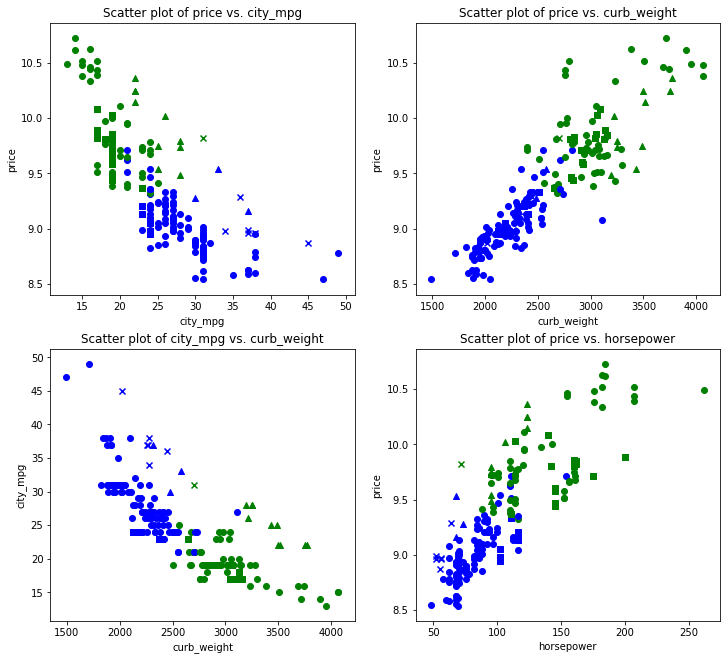

In [7]:
def plot_auto_cluster(auto_prices, assign_color, markers):
    fig, ax = plt.subplots(2, 2, figsize=(12,11)) # define plot area         
    x_cols = ['city_mpg', 'curb_weight', 'curb_weight', 'horsepower']
    y_cols = ['price', 'price', 'city_mpg', 'price']
    for x_col,y_col,i,j in zip(x_cols,y_cols,[0,0,1,1],[0,1,0,1]):
        for x,y,c,m in zip(auto_prices[x_col], auto_prices[y_col], assign_color, markers):
            ax[i,j].scatter(x,y, color = c, marker = m)
        ax[i,j].set_title('Scatter plot of ' + y_col + ' vs. ' + x_col) # Give the plot a main title
        ax[i,j].set_xlabel(x_col) # Set text for the x axis
        ax[i,j].set_ylabel(y_col)# Set text for y axis
    plt.show()

plot_auto_cluster(auto_prices, assign_color_km2, markers)

The K=2 clustering model has divided the data between high price, low fuel efficiency, high weight and high horsepower autos and ones that have the opposite characteristics. While this clustering is interesting, it can hardly be considered surprising. 

Next, execute the code in the cell below to compute and display the cluster assignments for the K=3 model. 

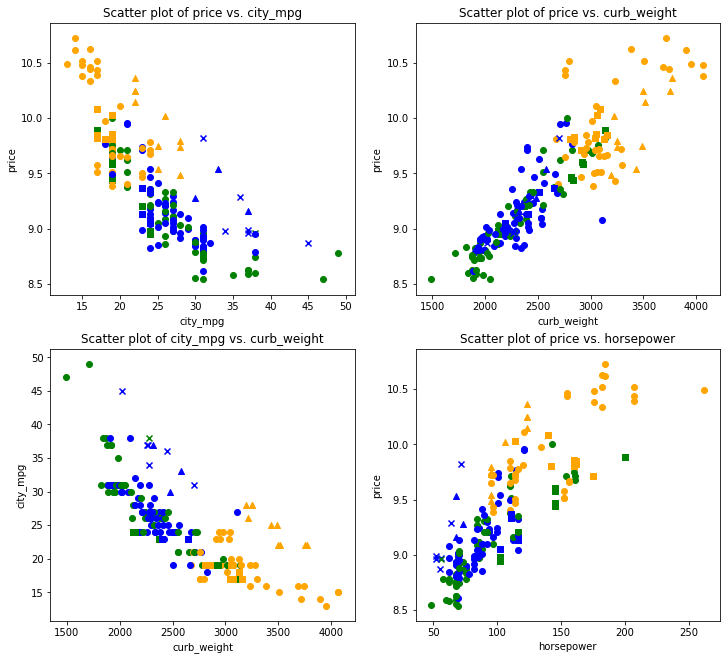

In [8]:
nr.seed(4455)
kmeans_3 = KMeans(n_clusters=3, random_state=0)
assignments_km3 = kmeans_3.fit_predict(Auto_Data)
assign_color_km3 = [col_dic[x] for x in assignments_km3]
plot_auto_cluster(auto_prices, assign_color_km3, markers)

The basic divisions of the dataset between the clusters is similar to the K=2 model case. However, there is significantly more overlap of these clusters than for the K=2 case. The standard aspiration autos are all in the cluster shown in blue. Beyond this, it is not completely clear what new information on the structure of this dataset has been learned. 

Execute the code in the cell below to compute and display the cluster assignments for the K=4 model. 

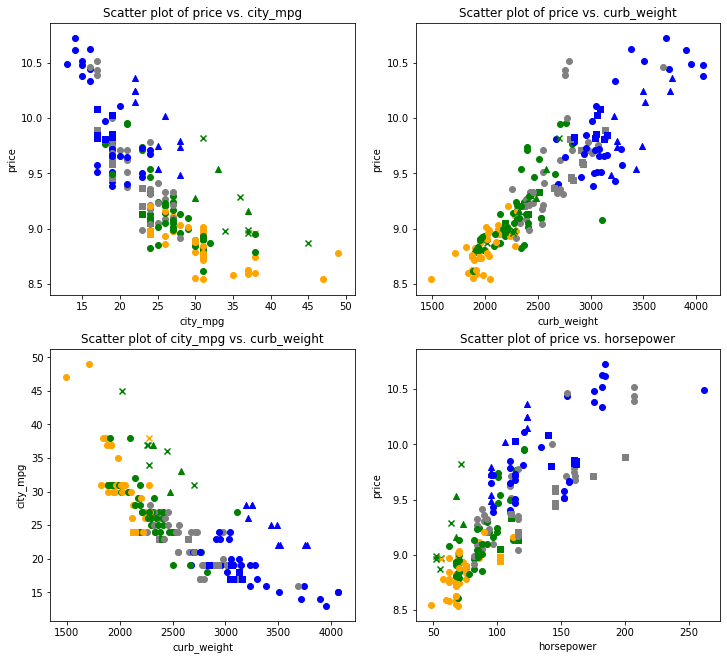

In [9]:
nr.seed(223)
kmeans_4 = KMeans(n_clusters=4, random_state=0)
assignments_km4 = kmeans_4.fit_predict(Auto_Data)
assign_color_km4 = [col_dic[x] for x in assignments_km4]
plot_auto_cluster(auto_prices, assign_color_km4, markers)

There appears to be less overlap when compared to the k=4 model. Further, some additional interesting structure is starting to emerge. Primary divisions of these clusters are by price, weight, fuel efficiency and horsepower. All of the diesel autos are in two clusters, one with high cost, weight and horse power in blue, and one for lower cost, weight and horse power in orange. 

Execute the code in the cell below to compute and display the cluster assignments for a K=5 model. 

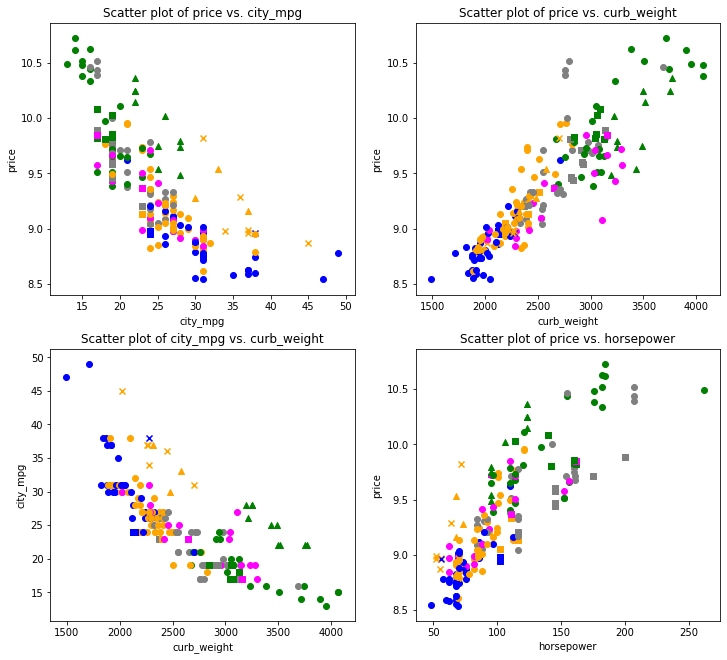

In [10]:
nr.seed(4443)
kmeans_5 = KMeans(n_clusters=5, random_state=0)
assignments_km5 = kmeans_5.fit_predict(Auto_Data)
assign_color_km5 = [col_dic[x] for x in assignments_km5]
plot_auto_cluster(auto_prices, assign_color_km5, markers)

The structure of these clusters is rather complex. The general pattern is similar to the K=4 model, but with finer grained divisions between the clusters. 

Finally, execute the code in the cell below to compute and display the class assignments for the K=6 model. 

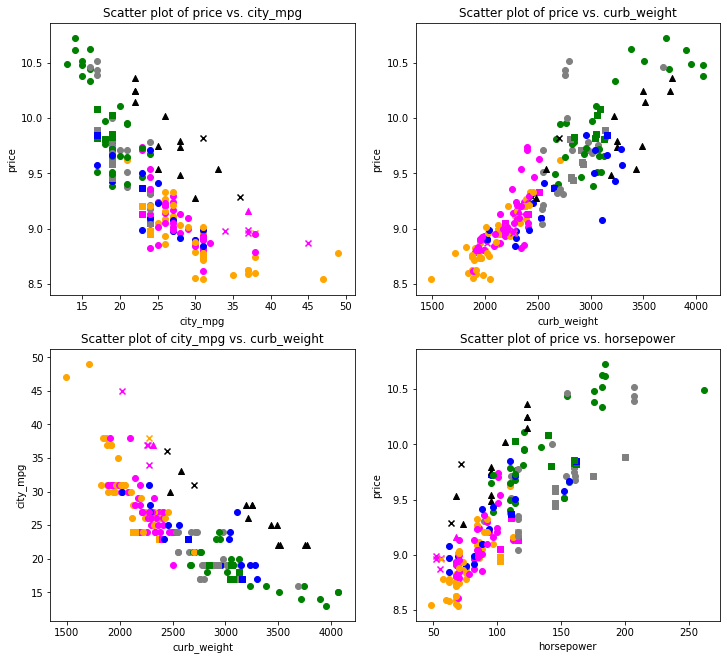

In [11]:
nr.seed(2288)
kmeans_6 = KMeans(n_clusters=6, random_state=0)
assignments_km6 = kmeans_6.fit_predict(Auto_Data)
assign_color_km6 = [col_dic[x] for x in assignments_km6]
plot_auto_cluster(auto_prices, assign_color_km6, markers)

The structure of these clusters follows the general pattern of the K=4 and K=5 models. The difference being that there is a finer grained divisions between the clusters.

While these visualizations are interesting, it is hard to select a best model based on just this evidence. To establish a quantitative basis for model selection, you will now compute and compare the within cluster sum of squares (WCSS), between cluster sum of squares (BCSS) and silhouette coefficient (SC) metrics. Execute the code in the cell below and examine the results.

195 46
8969.0


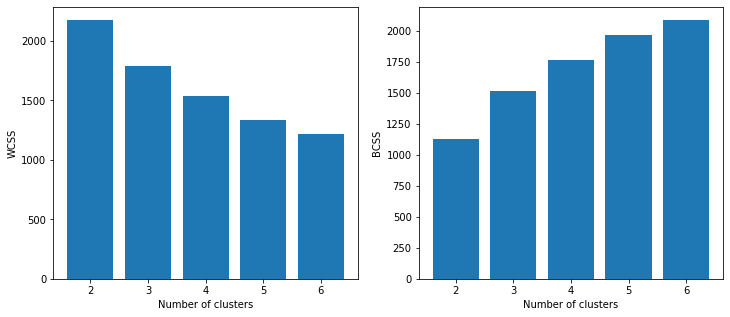

In [12]:
km_models = [kmeans_2, kmeans_3, kmeans_4, kmeans_5, kmeans_6]

def plot_WCSS_km(km_models, samples):
    fig, ax = plt.subplots(1, 2, figsize=(12,5))
    
    ## Plot WCSS
    wcss = [mod.inertia_ for mod in km_models]
    n_clusts = range(2,len(wcss) + 2)
    ax[0].bar(n_clusts, wcss)
    ax[0].set_xlabel('Number of clusters')
    ax[0].set_ylabel('WCSS')
    
    ## Plot BCSS
    ## Compute BCSS as TSS - WCSS 
    n_1 = (float(samples.shape[0]) * float(samples.shape[1])) - 1.0
    print(samples.shape[0],samples.shape[1])
    print(n_1)
    tss = n_1 * np.var(samples)
    bcss = [tss - x for x in wcss]
    ax[1].bar(n_clusts, bcss)
    ax[1].set_xlabel('Number of clusters')
    ax[1].set_ylabel('BCSS')
    plt.show()
    

plot_WCSS_km(km_models, Auto_Data)

The WCSS decreases with cluster number, rapidly at first. The BCSS increases with cluster number, again rapidly at first. These results indicate that higher numbers of clusters create models that are better at separating the clusters. 

Now, execute the code in the cell below to compute and display the SC for each of the cluster models. 

Then, answer **Question 1** on the course page.

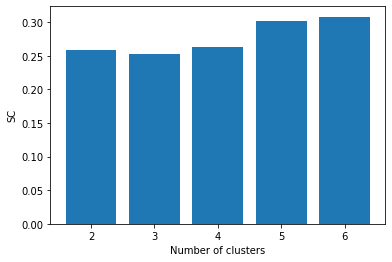

In [13]:
assignment_list = [assignments_km2, assignments_km3, assignments_km4, assignments_km5, assignments_km6]

def plot_sillohette(samples, assignments, x_lab = 'Number of clusters'):
    silhouette = [silhouette_score(samples, a) for a in assignments]
    n_clusts = range(2, len(silhouette) + 2)
    plt.bar(n_clusts, silhouette)
    plt.xlabel(x_lab)
    plt.ylabel('SC')
    plt.show()

plot_sillohette(Auto_Data, assignment_list)

The SC is highest for the K=6 model, but only marginally higher than K=5. The K=5 and K=6 models have significantly higher SC than for K=2, 3 or 4. However, all these SC values are fairly low.

Overall, it appears that the k=6 model is the best in terms of these metrics. It also appears that there is an improvement over the K=5 model

## Apply agglomerative clustering

Having tried the K-means clustering mode with various numbers of clusters, you will now try agglomerative clustering models. You will compare these models using both visualization and the SC metric.  

The code in the cell below computes a 2 cluster agglomerative model and displays the cluster assignments. Execute this code. 

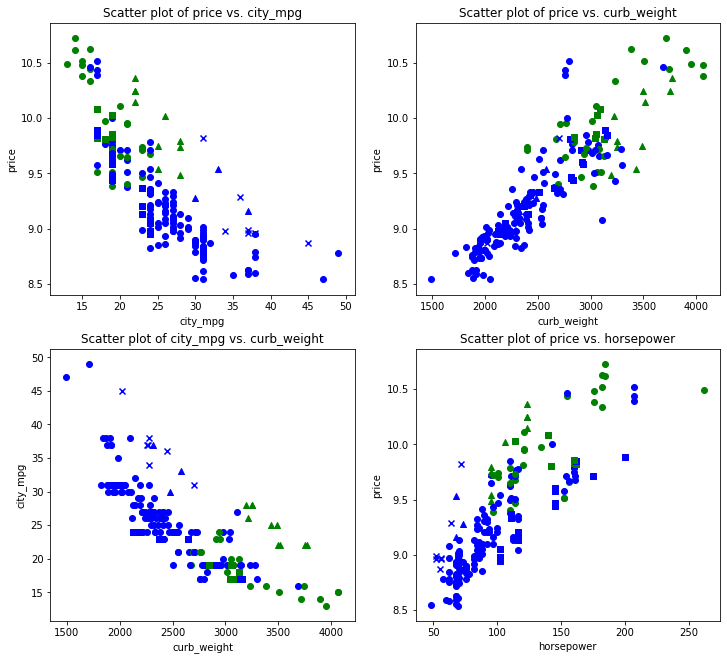

In [14]:
nr.seed(2233)
agc_2 = AgglomerativeClustering(n_clusters=2)
assignments_ag2 = agc_2.fit_predict(Auto_Data)
assign_color_ag2 = [col_dic[x] for x in assignments_ag2]
plot_auto_cluster(auto_prices, assign_color_ag2, markers)

Examine the above plots and compare them to the cluster assignments for the K=2 K-means model. Whereas the K-means model created an approximately even split of the dataset, the agglomerative clustering model has placed the majority of points in one cluster. There is considerable overlap in these views of the assignments for the agglomerative clustering model.

Next, execute the code in the cell below to compute and display the assignments for the  3 cluster agglomerative model. 

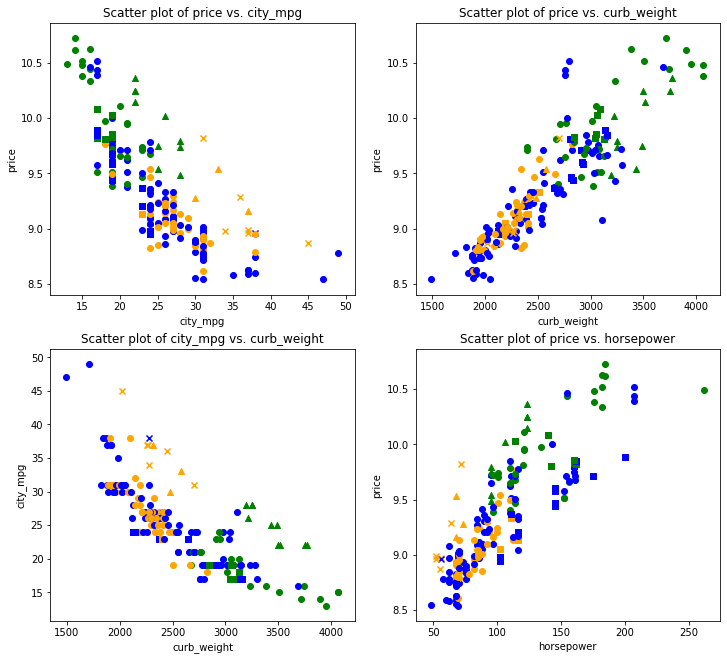

In [15]:
nr.seed(4433)
agc_3 = AgglomerativeClustering(n_clusters=3)
assignments_ag3 = agc_3.fit_predict(Auto_Data)
assign_color_ag3 = [col_dic[x] for x in assignments_ag3]
plot_auto_cluster(auto_prices, assign_color_ag3, markers)

Examine these plots and compare them to the 2 cluster model. It appears the 3 cluster model has split the larger cluster, but with considerable overlap in these views. 

Execute the code in the cell below to compute and display the cluster assignments for the 4 cluster agglomerative model. 

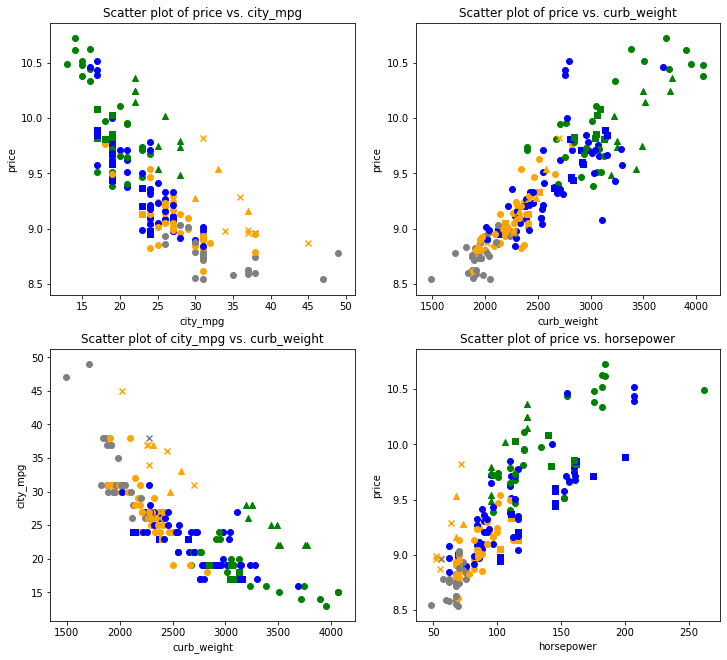

In [16]:
nr.seed(2663)
agc_4 = AgglomerativeClustering(n_clusters=4)
assignments_ag4 = agc_4.fit_predict(Auto_Data)
assign_color_ag4 = [col_dic[x] for x in assignments_ag4]
plot_auto_cluster(auto_prices, assign_color_ag4, markers)

Compare these cluster assignments to the 3 cluster model. Notice that low weight, low horsepower and low cost autos have been split into two clusters. Further, all diesel cars are in two clusters. 

Execute the code in the cell below to compute and display the cluster assignments for a 5 cluster model.

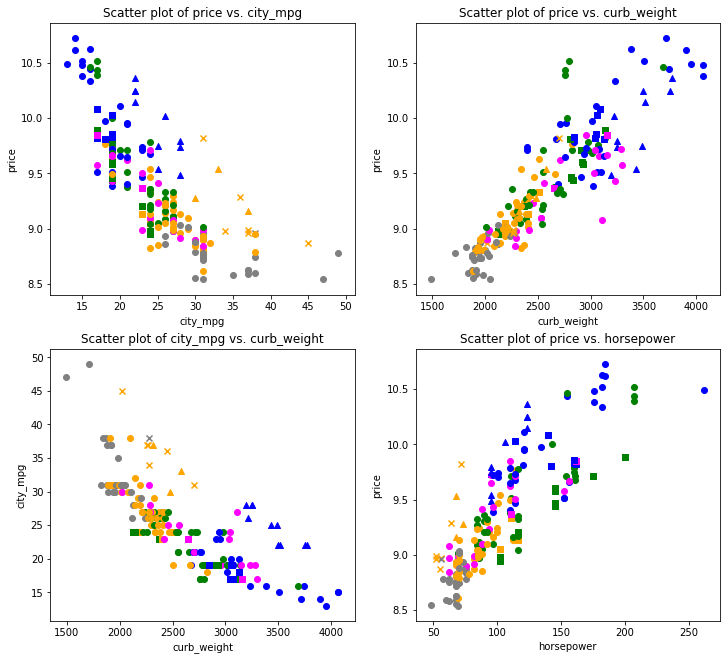

In [17]:
nr.seed(6233)
agc_5 = AgglomerativeClustering(n_clusters=5)
assignments_ag5 = agc_5.fit_predict(Auto_Data)
assign_color_ag5 = [col_dic[x] for x in assignments_ag5]
plot_auto_cluster(auto_prices, assign_color_ag5, markers)

These results are complex and hard to interpret. The data are now in multiple clusters with considerable overlap. Still, some patterns are visible with distinct fuel-aspiration combinations divided into distinct clusters, for example. 

Finally, execute the code in the cell below to compute and display the assignments for the 6 cluster agglomerative model.

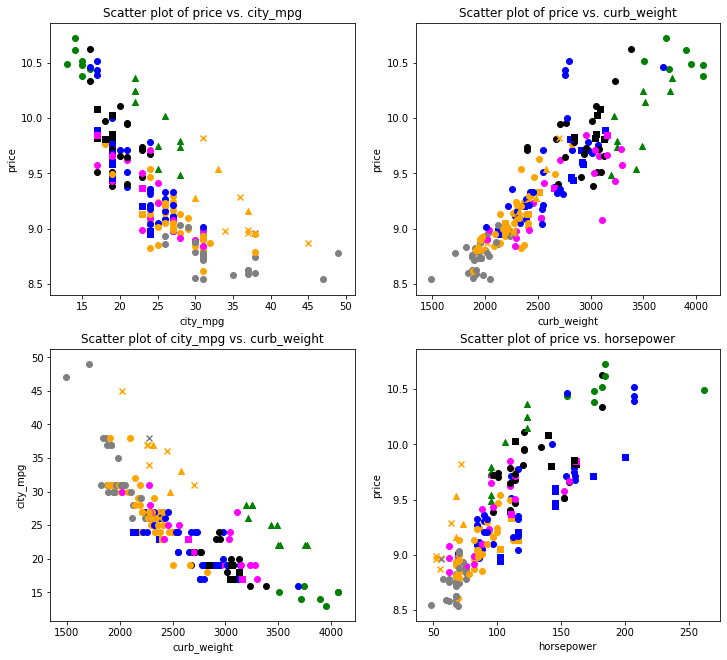

In [18]:
nr.seed(2288)
agc_6 = AgglomerativeClustering(n_clusters=6)
assignments_ag6 = agc_6.fit_predict(Auto_Data)
assign_color_ag6 = [col_dic[x] for x in assignments_ag6]
plot_auto_cluster(auto_prices, assign_color_ag6, markers)

These results appear simpler to the 5 cluster agglomerative model. Some clusters are clearly separated but there is considerable overlap in other cases. 

Finally, execute the code in the cell below to compute and display the SC for the agglomerative clustering models. 

Then, answer **Question 2** on the course page.

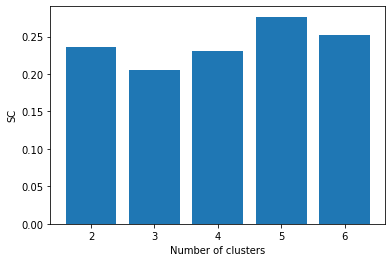

In [19]:
assignment_list = [assignments_ag2, assignments_ag3, assignments_ag4, assignments_ag5, assignments_ag6]
plot_sillohette(Auto_Data, assignment_list)

The 5 cluster agglomerative model has the largest SC. The SC for this model is marginally higher than the 6 cluster model. It appears that the 5 cluster model is preferred. None of these models has a particularly high SC.

## Summary

In this lab you have computed, evaluated and compared K-means and agglomerative clustering models with 2, 3, 4, 5 and 6 clusters applied to the automotive dataset. As is often the case with unsupervised learning, it has proven difficult to compare models. It is also challenging to determine the most interesting aspects of data structure discovered by the clustering process. 

Specifically, your analysis discovered:
1. The K=6 model appears to be the best of the K-means clustering model tried. Some interesting structure was revealed in this analysis, but overall the reduction in BCSS and SC were relatively low. 
2. The 5 cluster agglomerative model appears the be the best of those tried. As with the K-means model, some interesting structure was revealed, but the SC values were relatively low. 

Cluster analysis of the automotive data can be extended in a number of ways, including:
1. Use larger numbers of clusters to determine if finer groupings reveal structure. 
2. For agglomerative clustering model try other linkage functions and distance metrics. 

In [20]:
import pandas as pd 
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)